Note: Unduh dataset Indonesia Reading Interest https://www.kaggle.com/datasets/imaditia/indonesia-reading-interest-2020-2023?resource=download dan unggah melalui menu unggah file di samping. Anda juga bisa mengunggahnya pada Google Drive untuk di-mount

In [ ]:
# 1. Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Ensure plots display inline in Colab
%matplotlib inline

In [ ]:
# 2. Read the dataset
# Make sure you have uploaded the dataset file (archive.zip) to your Colab environment
# or mounted your Google Drive and updated the path accordingly.
df = pd.read_csv("/content/archive.zip", sep=";")

# Print detected column names
print("=== Detected Columns ===")
print(df.columns.tolist(), "\n")

=== Detected Columns ===
['Provinsi', 'Year', 'Reading Frequency per week', 'Number of Readings per Quarter', 'Daily Reading Duration (in minutes)', 'Internet Access Frequency per Week', 'Daily Internet Duration (in minutes)', 'Tingkat Kegemaran Membaca (Reading Interest)', 'Category'] 



In [ ]:
# 3. Display the first few rows to verify the structure
print("=== First 5 Rows ===")
print(df.head(), "\n")

=== First 5 Rows ===
  Provinsi  Year Reading Frequency per week Number of Readings per Quarter  \
0     Aceh  2020                          4                              2   
1     Aceh  2021                        5,5                            4,5   
2     Aceh  2022                          5                            5,5   
3     Aceh  2023                          5                            5,5   
4     Bali  2020                          4                            2,5   

  Daily Reading Duration (in minutes) Internet Access Frequency per Week  \
0                                  95                                NaN   
1                                 103                                  5   
2                                94,3                                5,5   
3                                  95                                5,5   
4                                  91                                NaN   

  Daily Internet Duration (in minutes)  \
0          

In [ ]:
# 4. Basic exploration: info, describe, missing values
print("=== DataFrame Info ===")
print(df.info(), "\n")
print("=== Descriptive Statistics ===")
print(df.describe(include='all'), "\n")
print("=== Missing Values Per Column ===")
print(df.isnull().sum(), "\n")

=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Provinsi                                      140 non-null    object
 1   Year                                          140 non-null    int64 
 2   Reading Frequency per week                    140 non-null    object
 3   Number of Readings per Quarter                140 non-null    object
 4   Daily Reading Duration (in minutes)           140 non-null    object
 5   Internet Access Frequency per Week            105 non-null    object
 6   Daily Internet Duration (in minutes)          105 non-null    object
 7   Tingkat Kegemaran Membaca (Reading Interest)  140 non-null    object
 8   Category                                      140 non-null    object
dtypes: int64(1), object(8)
memory usage: 10.0+ KB
None 

=

In [ ]:
# 5. Remove duplicate rows (if any)
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)
if duplicates > 0:
    df = df.drop_duplicates()
    print("After removing duplicates, shape:", df.shape, "\n")
else:
    print("No duplicate rows found.\n")

Number of duplicate rows: 0
No duplicate rows found.



In [ ]:
# 6. Handle missing values and convert columns that contain commas to proper numeric
# Define the reading interest column
reading_col = "Tingkat Kegemaran Membaca (Reading Interest)"

# List of columns with numeric values stored as strings (with commas)
numeric_cols_with_commas = [
    "Reading Frequency per week",
    "Number of Readings per Quarter",
    "Daily Reading Duration (in minutes)",
    "Internet Access Frequency per Week",
    "Daily Internet Duration (in minutes)",
    reading_col
]

for col in numeric_cols_with_commas:
    if col in df.columns:
        # Replace commas with dots
        df[col] = df[col].astype(str).str.replace(',', '.')
        # Convert to numeric
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Fill missing with median
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Missing values in '{col}' filled with median: {median_val}")

# Convert "Year" to numeric if it exists
if 'Year' in df.columns:
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    year_median = df['Year'].median()
    df['Year'] = df['Year'].fillna(year_median)
    print(f"Missing values in 'Year' filled with median: {year_median}")

# Fill missing values in categorical columns with mode
categorical_cols = ["Provinsi", "Category"]
for cat_col in categorical_cols:
    if cat_col in df.columns:
        mode_val = df[cat_col].mode()[0]
        df[cat_col] = df[cat_col].fillna(mode_val)
        print(f"Missing values in '{cat_col}' filled with mode: {mode_val}")
print()

Missing values in 'Reading Frequency per week' filled with median: 4.75
Missing values in 'Number of Readings per Quarter' filled with median: 4.5
Missing values in 'Daily Reading Duration (in minutes)' filled with median: 97.2
Missing values in 'Internet Access Frequency per Week' filled with median: 5.5
Missing values in 'Daily Internet Duration (in minutes)' filled with median: 113.7
Missing values in 'Tingkat Kegemaran Membaca (Reading Interest)' filled with median: 62.195
Missing values in 'Year' filled with median: 2021.5
Missing values in 'Provinsi' filled with mode: Aceh
Missing values in 'Category' filled with mode: Moderate



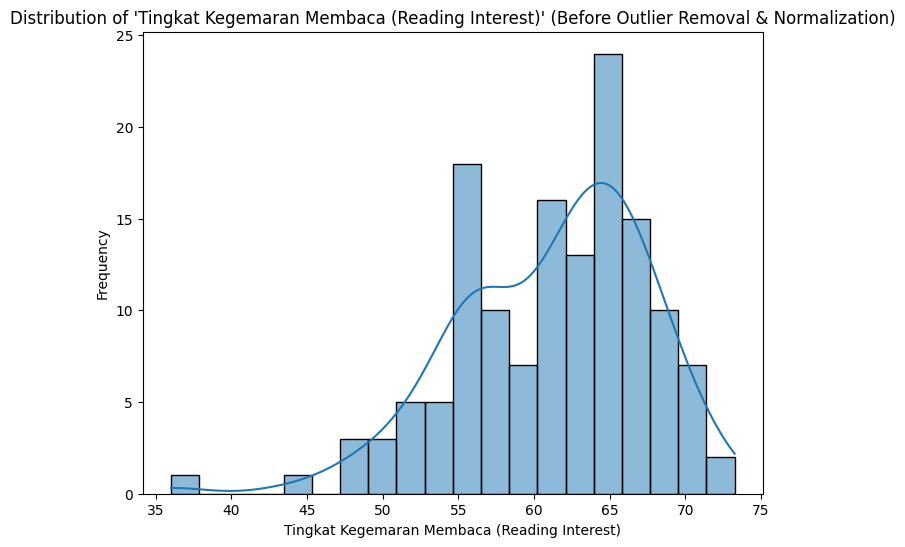

In [ ]:
# 7. Visualize the reading interest BEFORE normalization
plt.figure(figsize=(8, 6))
sns.histplot(df[reading_col], bins=20, kde=True)
plt.title(f"Distribution of '{reading_col}' (Before Outlier Removal & Normalization)")
plt.xlabel(reading_col)
plt.ylabel("Frequency")
plt.show()

In [ ]:
# === Extra Cleaning Steps After Outlier Removal and Before Normalization ===

# Detect and remove outliers using the IQR method
def remove_outliers_iqr(data, cols):
    data_clean = data.copy()
    for c in cols:
        Q1 = data_clean[c].quantile(0.25)
        Q3 = data_clean[c].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_indices = data_clean[(data_clean[c] < lower_bound) | (data_clean[c] > upper_bound)].index
        print(f"Column '{c}': {len(outlier_indices)} outliers detected.")
        data_clean = data_clean.drop(index=outlier_indices)
    return data_clean

# Identify numeric columns for outlier detection
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols, "\n")

# Remove outliers from numeric columns
df_no_outliers = remove_outliers_iqr(df, numeric_cols)
print("\nShape after outlier removal:", df_no_outliers.shape)

# 1. Re-check missing values after outlier removal
print("Missing values per column (after outlier removal):")
print(df_no_outliers.isnull().sum(), "\n")

# (Optional) Fill or drop missing values if needed
# Example: fill numeric NaN with median
for col in df_no_outliers.select_dtypes(include=[np.number]).columns:
    df_no_outliers[col] = df_no_outliers[col].fillna(df_no_outliers[col].median())

# 2. Check skewness of numeric features
print("Skewness of numeric columns:")
print(df_no_outliers[numeric_cols].skew(), "\n")

# (Optional) Apply log transform to reduce skewness (only for positive values)
for col in numeric_cols:
    if (df_no_outliers[col] > 0).all() and abs(df_no_outliers[col].skew()) > 1:
        print(f"Applying log1p transform to '{col}' (skewness too high).")
        df_no_outliers[col] = np.log1p(df_no_outliers[col])

# 3. Decide which columns should be normalized (exclude binary/encoded)
numeric_cols = [
    col for col in df_no_outliers.select_dtypes(include=[np.number]).columns
    if df_no_outliers[col].nunique() > 2
]
print("Columns to normalize:", numeric_cols, "\n")

Numeric columns: ['Year', 'Reading Frequency per week', 'Number of Readings per Quarter', 'Daily Reading Duration (in minutes)', 'Internet Access Frequency per Week', 'Daily Internet Duration (in minutes)', 'Tingkat Kegemaran Membaca (Reading Interest)'] 

Column 'Year': 0 outliers detected.
Column 'Reading Frequency per week': 13 outliers detected.
Column 'Number of Readings per Quarter': 0 outliers detected.
Column 'Daily Reading Duration (in minutes)': 3 outliers detected.
Column 'Internet Access Frequency per Week': 39 outliers detected.
Column 'Daily Internet Duration (in minutes)': 7 outliers detected.
Column 'Tingkat Kegemaran Membaca (Reading Interest)': 1 outliers detected.

Shape after outlier removal: (77, 9)
Missing values per column (after outlier removal):
Provinsi                                        0
Year                                            0
Reading Frequency per week                      0
Number of Readings per Quarter                  0
Daily Reading Durat

Numeric columns: ['Year', 'Reading Frequency per week', 'Number of Readings per Quarter', 'Daily Reading Duration (in minutes)', 'Internet Access Frequency per Week', 'Daily Internet Duration (in minutes)', 'Tingkat Kegemaran Membaca (Reading Interest)'] 

Column 'Year': 0 outliers detected.
Column 'Reading Frequency per week': 13 outliers detected.
Column 'Number of Readings per Quarter': 0 outliers detected.
Column 'Daily Reading Duration (in minutes)': 3 outliers detected.
Column 'Internet Access Frequency per Week': 39 outliers detected.
Column 'Daily Internet Duration (in minutes)': 7 outliers detected.
Column 'Tingkat Kegemaran Membaca (Reading Interest)': 1 outliers detected.

Shape after outlier removal: (77, 9)


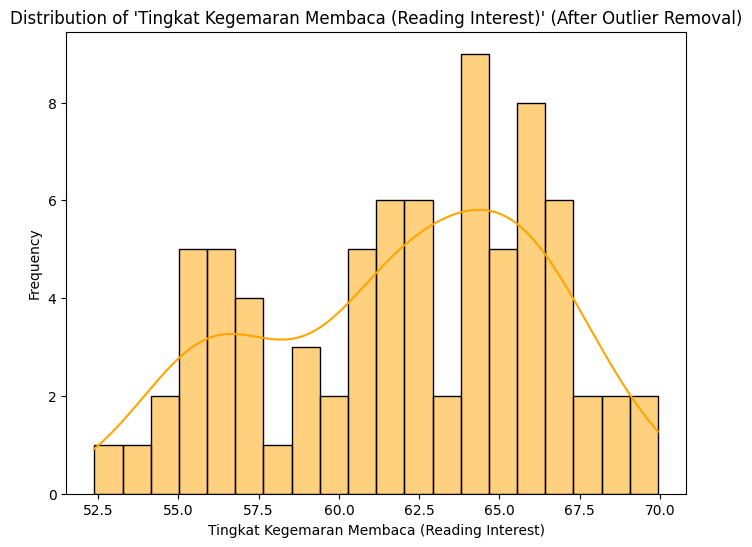

In [ ]:
# 8. Detect and remove outliers using the IQR method
def remove_outliers_iqr(data, cols):
    data_clean = data.copy()
    for c in cols:
        Q1 = data_clean[c].quantile(0.25)
        Q3 = data_clean[c].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_indices = data_clean[(data_clean[c] < lower_bound) | (data_clean[c] > upper_bound)].index
        print(f"Column '{c}': {len(outlier_indices)} outliers detected.")
        data_clean = data_clean.drop(index=outlier_indices)
    return data_clean

# Identify numeric columns for outlier detection
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols, "\n")

# Remove outliers from numeric columns
df_no_outliers = remove_outliers_iqr(df, numeric_cols)
print("\nShape after outlier removal:", df_no_outliers.shape)

# Visualize the reading interest AFTER outlier removal
plt.figure(figsize=(8, 6))
sns.histplot(df_no_outliers[reading_col], bins=20, kde=True, color='orange')
plt.title(f"Distribution of '{reading_col}' (After Outlier Removal)")
plt.xlabel(reading_col)
plt.ylabel("Frequency")
plt.show()

Column 'Year': 0 outliers detected (Z-score).
Column 'Reading Frequency per week': 0 outliers detected (Z-score).
Column 'Number of Readings per Quarter': 0 outliers detected (Z-score).
Column 'Daily Reading Duration (in minutes)': 2 outliers detected (Z-score).
Column 'Internet Access Frequency per Week': 8 outliers detected (Z-score).
Column 'Daily Internet Duration (in minutes)': 3 outliers detected (Z-score).
Column 'Tingkat Kegemaran Membaca (Reading Interest)': 1 outliers detected (Z-score).
Shape after Z-score outlier removal: (126, 9)


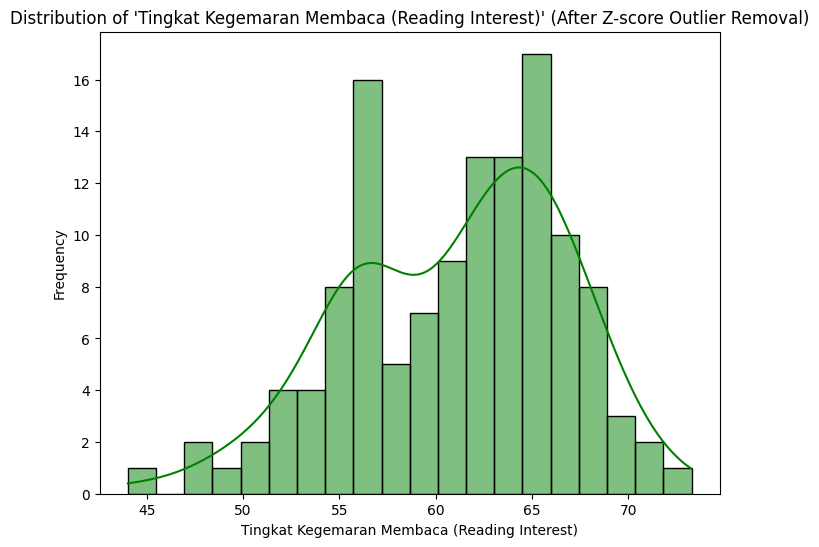

In [ ]:
# === Remove Outliers using Z-Score Method ===
from scipy import stats

def remove_outliers_zscore(data, cols, threshold=3):
    data_clean = data.copy()
    for c in cols:
        z_scores = np.abs(stats.zscore(data_clean[c]))
        outlier_indices = data_clean[z_scores > threshold].index
        print(f"Column '{c}': {len(outlier_indices)} outliers detected (Z-score).")
        data_clean = data_clean.drop(outlier_indices)
    return data_clean

# Apply Z-score outlier removal
df_no_outliers_z = remove_outliers_zscore(df, numeric_cols)
print("Shape after Z-score outlier removal:", df_no_outliers_z.shape)

# === Visualize Histogram After Outlier Removal ===
plt.figure(figsize=(8, 6))
sns.histplot(df_no_outliers_z[reading_col], bins=20, kde=True, color='green')
plt.title(f"Distribution of '{reading_col}' (After Z-score Outlier Removal)")
plt.xlabel(reading_col)
plt.ylabel("Frequency")
plt.show()

Column 'Year': Winsorized to 1.0% - 99.0% range.
Column 'Reading Frequency per week': Winsorized to 1.0% - 99.0% range.
Column 'Number of Readings per Quarter': Winsorized to 1.0% - 99.0% range.
Column 'Daily Reading Duration (in minutes)': Winsorized to 1.0% - 99.0% range.
Column 'Internet Access Frequency per Week': Winsorized to 1.0% - 99.0% range.
Column 'Daily Internet Duration (in minutes)': Winsorized to 1.0% - 99.0% range.
Column 'Tingkat Kegemaran Membaca (Reading Interest)': Winsorized to 1.0% - 99.0% range.


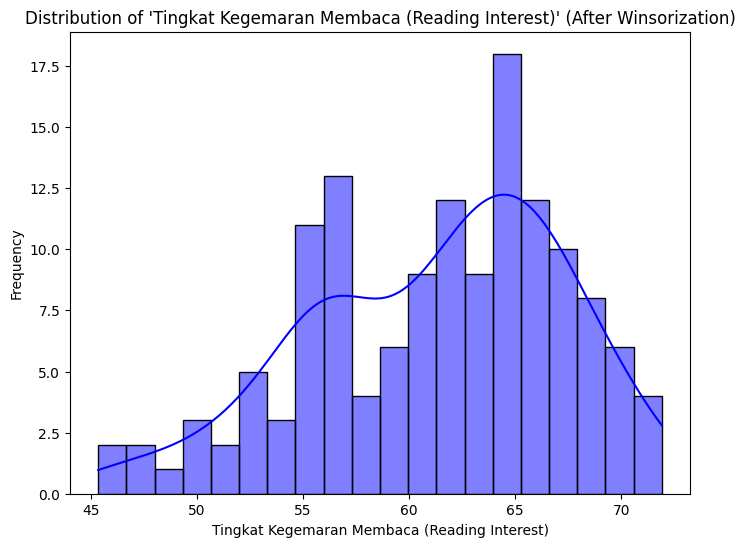

In [ ]:
# === Winsorization Method (Capping Outliers) ===
def winsorize_outliers(data, cols, lower=0.01, upper=0.99):
    data_clean = data.copy()
    for c in cols:
        lower_bound = data_clean[c].quantile(lower)
        upper_bound = data_clean[c].quantile(upper)
        data_clean[c] = np.clip(data_clean[c], lower_bound, upper_bound)
        print(f"Column '{c}': Winsorized to {lower*100}% - {upper*100}% range.")
    return data_clean

# Apply Winsorization
df_winsorized = winsorize_outliers(df, numeric_cols)

# === Visualize Histogram After Winsorization ===
plt.figure(figsize=(8, 6))
sns.histplot(df_winsorized[reading_col], bins=20, kde=True, color='blue')
plt.title(f"Distribution of '{reading_col}' (After Winsorization)")
plt.xlabel(reading_col)
plt.ylabel("Frequency")
plt.show()

Column 'Year': removed 0 rows outside 1.0% - 99.0% range.
Column 'Reading Frequency per week': removed 2 rows outside 1.0% - 99.0% range.
Column 'Number of Readings per Quarter': removed 2 rows outside 1.0% - 99.0% range.
Column 'Daily Reading Duration (in minutes)': removed 4 rows outside 1.0% - 99.0% range.
Column 'Internet Access Frequency per Week': removed 2 rows outside 1.0% - 99.0% range.
Column 'Daily Internet Duration (in minutes)': removed 4 rows outside 1.0% - 99.0% range.
Column 'Tingkat Kegemaran Membaca (Reading Interest)': removed 4 rows outside 1.0% - 99.0% range.


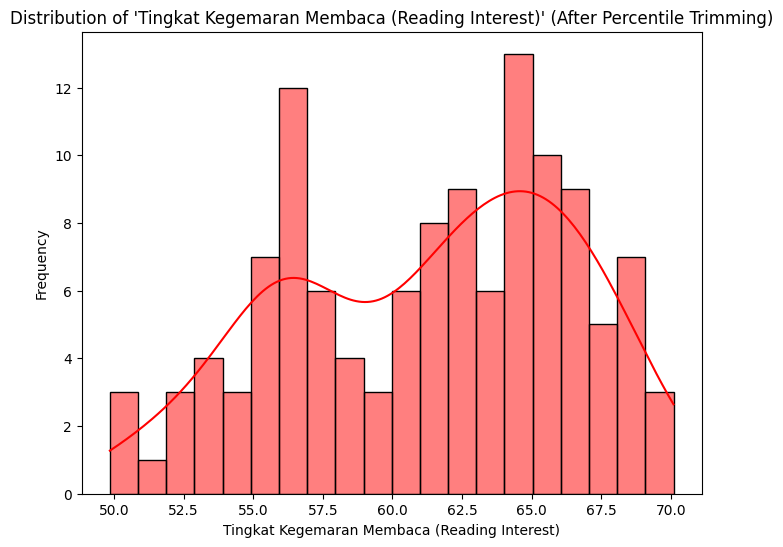

In [ ]:
# === Percentile Trimming Method ===
def percentile_trim(data, cols, lower=0.01, upper=0.99):
    data_clean = data.copy()
    for c in cols:
        low = data_clean[c].quantile(lower)
        high = data_clean[c].quantile(upper)
        before = data_clean.shape[0]
        data_clean = data_clean[(data_clean[c] >= low) & (data_clean[c] <= high)]
        after = data_clean.shape[0]
        print(f"Column '{c}': removed {before - after} rows outside {lower*100}% - {upper*100}% range.")
    return data_clean

# Apply Percentile Trimming
df_percentile = percentile_trim(df, numeric_cols)

# Visualize
plt.figure(figsize=(8, 6))
sns.histplot(df_percentile[reading_col], bins=20, kde=True, color='red')
plt.title(f"Distribution of '{reading_col}' (After Percentile Trimming)")
plt.xlabel(reading_col)
plt.ylabel("Frequency")
plt.show()

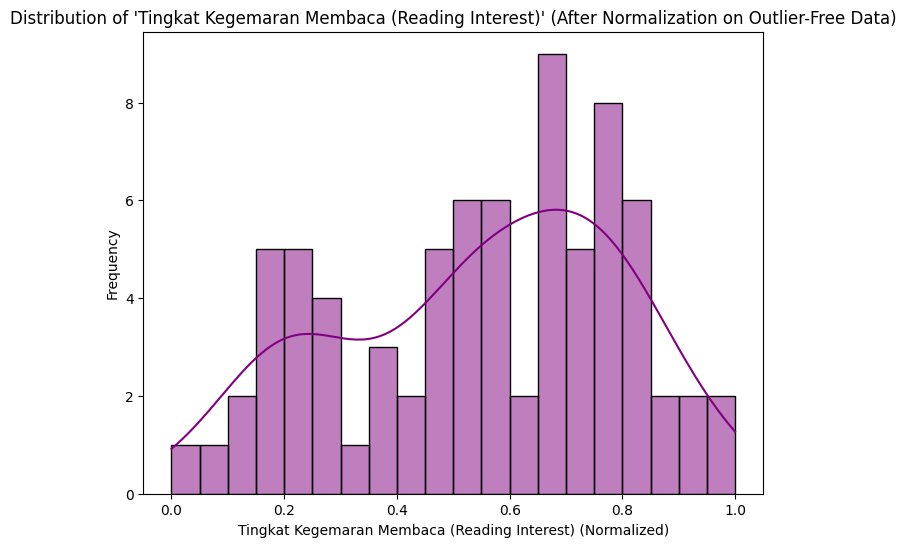


Sample of normalized data (after outlier removal):
  Provinsi      Year  Reading Frequency per week  \
0     Aceh  0.000000                    0.000000   
2     Aceh  0.666667                    0.666667   
3     Aceh  1.000000                    0.666667   
4     Bali  0.000000                    0.000000   
5     Bali  0.333333                    1.000000   

   Number of Readings per Quarter  Daily Reading Duration (in minutes)  \
0                           0.000                             0.309577   
2                           0.875                             0.293987   
3                           0.875                             0.309577   
4                           0.125                             0.220490   
5                           0.625                             0.020045   

   Internet Access Frequency per Week  Daily Internet Duration (in minutes)  \
0                                 0.0                              0.496324   
2                               

In [ ]:
# 9. Normalize the data AFTER outlier removal using MinMaxScaler
df_no_outliers_normalized = df_no_outliers.copy()
scaler = MinMaxScaler()
# Re-identify numeric columns in the outlier-removed dataset
numeric_cols_no_outliers = df_no_outliers_normalized.select_dtypes(include=[np.number]).columns.tolist()
df_no_outliers_normalized[numeric_cols_no_outliers] = scaler.fit_transform(df_no_outliers_normalized[numeric_cols_no_outliers])

# Visualize the reading interest AFTER normalization
plt.figure(figsize=(8, 6))
sns.histplot(df_no_outliers_normalized[reading_col], bins=20, kde=True, color='purple')
plt.title(f"Distribution of '{reading_col}' (After Normalization on Outlier-Free Data)")
plt.xlabel(f"{reading_col} (Normalized)")
plt.ylabel("Frequency")
plt.show()

print("\nSample of normalized data (after outlier removal):")
print(df_no_outliers_normalized.head())

In [ ]:
# 10. Save the preprocessed datasets
df_no_outliers_normalized.to_csv("TGM_2020-2023_normalized.csv", index=False)
df_no_outliers.to_csv("TGM_2020-2023_cleaned.csv", index=False)
print("\nNormalized dataset (outlier-free) saved as 'TGM_2020-2023_normalized.csv'.")
print("Cleaned (no outliers) dataset saved as 'TGM_2020-2023_cleaned.csv'.")


Normalized dataset (outlier-free) saved as 'TGM_2020-2023_normalized.csv'.
Cleaned (no outliers) dataset saved as 'TGM_2020-2023_cleaned.csv'.
